# 2. Modelling

In [3]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

import cv2
import os

2023-06-30 18:49:08.199167: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## 2.0. Uploaded (rescaled) preprocessed images/labels and renormalise them

In [4]:
# Load preprocessed training images and labels
train_input_dir = '../data/preprocessed/train'

train_images = []
train_labels = []

for i in range(120):
    image_filename = f"rescaled_preprocessed_image_{i}.jpg"
    image_path = os.path.join(train_input_dir, image_filename)
    image = cv2.imread(image_path)
    train_images.append(image)

    label_filename = f"rescaled_preprocessed_label_{i}.png"
    label_path = os.path.join(train_input_dir, label_filename)
    label = cv2.imread(label_path, cv2.IMREAD_GRAYSCALE)
    train_labels.append(label)

# Load preprocessed validation images and labels
val_input_dir = '../data/preprocessed/valid'

val_images = []
val_labels = []

for i in range(30):
    image_filename = f"rescaled_preprocessed_image_{i}.jpg"
    image_path = os.path.join(val_input_dir, image_filename)
    image = cv2.imread(image_path)
    val_images.append(image)

    label_filename = f"rescaled_preprocessed_label_{i}.png"
    label_path = os.path.join(val_input_dir, label_filename)
    label = cv2.imread(label_path, cv2.IMREAD_GRAYSCALE)
    val_labels.append(label)

# Load preprocessed test images
test_input_dir = '../data/preprocessed/test'

test_images = []

for i in range(5):
    image_filename = f"rescaled_preprocessed_image_{i}.jpg"
    image_path = os.path.join(test_input_dir, image_filename)
    image = cv2.imread(image_path)
    test_images.append(image)


How big have we made our training set? 120
Some examples:


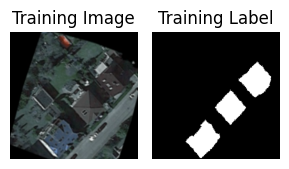

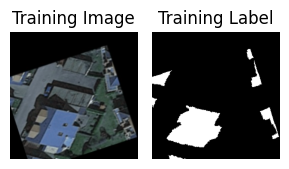

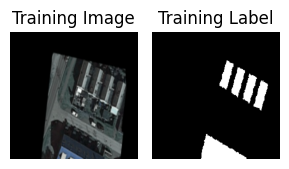

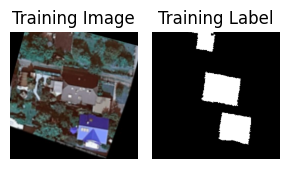

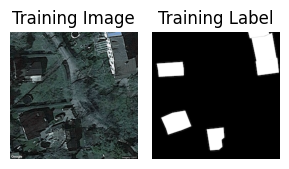

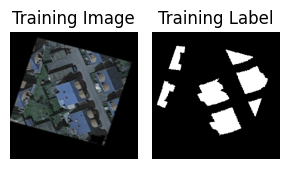

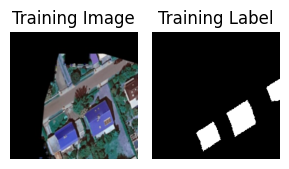

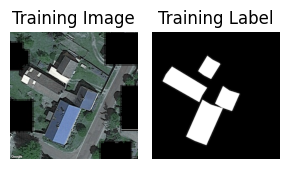

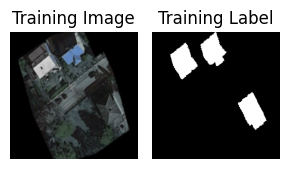

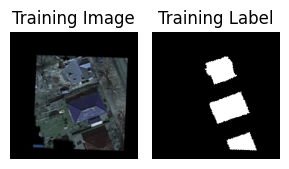

In [5]:
print(f"How big have we made our training set? {len(train_images)}")
print("Some examples:")

for index in range(len(train_images))[-10:]:

    plt.figure(figsize=(3,2))
    # Training image
    plt.subplot(1, 2, 1)
    plt.imshow(train_images[index])
    plt.title('Training Image')
    plt.axis('off')

    # Training label
    plt.subplot(1, 2, 2)
    plt.imshow(train_labels[index], cmap='gray')
    plt.title('Training Label')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

In [6]:
# Normalize pixel values
train_images = np.array(train_images) / 255.0
train_labels = np.array(train_labels) / 255.0

val_images = np.array(val_images) / 255.0
val_labels = np.array(val_labels) / 255.0

test_images = np.array(test_images) / 255.0

## 2.1 Network Architechture

We choose
Design a CNN architecture suitable for the image segmentation task. U-Net, SegNet, or Mask R-CNN are popular choices for such tasks. The network should take the input image as input and generate a binary mask where the roofs' boundaries are represented as white pixels (255) and the rest of the image as black (0).

U-Net is a popular choice due to its effectiveness in capturing spatial information. Below is an example implementation of the U-Net architecture:

In [7]:
def unet(input_shape):
    inputs = keras.layers.Input(input_shape)

    # Contracting Path (Encoder)
    conv1 = keras.layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = keras.layers.Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = keras.layers.Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = keras.layers.Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = keras.layers.Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = keras.layers.Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = keras.layers.Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = keras.layers.Conv2D(512, 3, activation='relu', padding='same')(conv4)
    pool4 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv4)

    # Bottom of U-Net
    conv5 = keras.layers.Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = keras.layers.Conv2D(1024, 3, activation='relu', padding='same')(conv5)

    # Expanding Path (Decoder)
    up6 = keras.layers.concatenate([keras.layers.UpSampling2D(size=(2, 2))(conv5), conv4], axis=3)
    conv6 = keras.layers.Conv2D(512, 3, activation='relu', padding='same')(up6)
    conv6 = keras.layers.Conv2D(512, 3, activation='relu', padding='same')(conv6)

    up7 = keras.layers.concatenate([keras.layers.UpSampling2D(size=(2, 2))(conv6), conv3], axis=3)
    conv7 = keras.layers.Conv2D(256, 3, activation='relu', padding='same')(up7)
    conv7 = keras.layers.Conv2D(256, 3, activation='relu', padding='same')(conv7)

    up8 = keras.layers.concatenate([keras.layers.UpSampling2D(size=(2, 2))(conv7), conv2], axis=3)
    conv8 = keras.layers.Conv2D(128, 3, activation='relu', padding='same')(up8)
    conv8 = keras.layers.Conv2D(128, 3, activation='relu', padding='same')(conv8)

    up9 = keras.layers.concatenate([keras.layers.UpSampling2D(size=(2, 2))(conv8), conv1], axis=3)
    conv9 = keras.layers.Conv2D(64, 3, activation='relu', padding='same')(up9)
    conv9 = keras.layers.Conv2D(64, 3, activation='relu', padding='same')(conv9)

    conv10 = keras.layers.Conv2D(1, 1, activation='sigmoid')(conv9)
    model = keras.models.Model(inputs=inputs, outputs=conv10)
    
    return model


In [8]:
model = unet(input_shape=(256, 256, 3))  # Adjust input shape as per your images
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [9]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

In [10]:
train_images.shape

(120, 256, 256, 3)

In [11]:
# Assuming you have preprocessed training data and labels in X_train and y_train
history = model.fit(train_images[:20], train_labels[:20], batch_size=1, epochs=5, validation_split=0.2)

Epoch 1/5


KeyboardInterrupt: 

In [ ]:
# Save the entire model
model.save('../models/baseline.h5')

# Load the saved model
#from tensorflow.keras.models import load_model
#model = load_model("../models/baseline.h5")

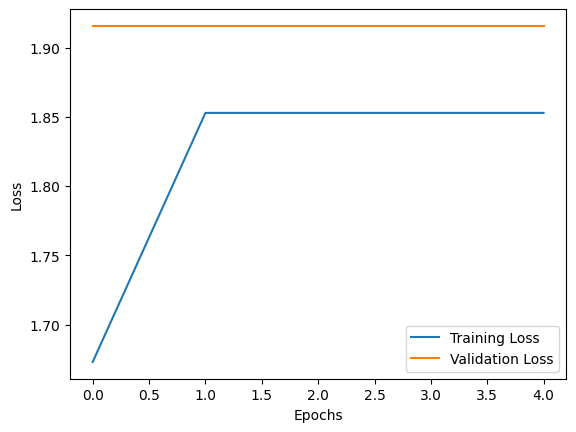

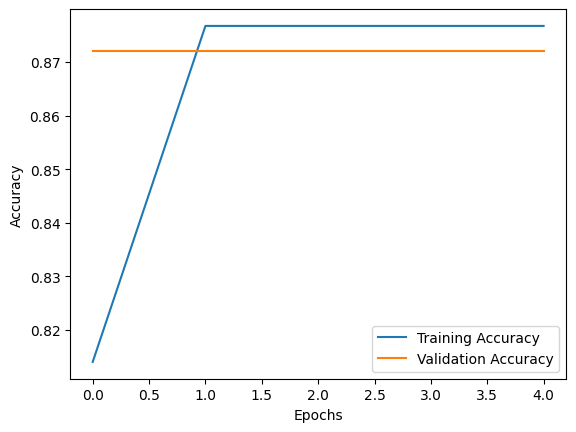

In [ ]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Plotting the loss curve
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting the accuracy curve
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [ ]:
# Assuming you have preprocessed validation data and labels in X_val and y_val
loss, accuracy = model.evaluate(val_images, val_labels)

1/1 [==============================] - 18s 18s/step - loss: 1.9322 - accuracy: 0.8707


In [ ]:
# Assuming you have preprocessed test data in X_test
predictions = model.predict(test_images)

1/1 [==============================] - 3s 3s/step


In [ ]:
# Apply thresholding to convert predicted masks to binary images
def post_process(predictions, threshold=0.5):
    binary_images = (predictions > threshold).astype(np.uint8)
    return binary_images

processed_predictions = post_process(predictions, threshold=0.1)

In [ ]:
processed_predictions.shape

(5, 256, 256, 1)

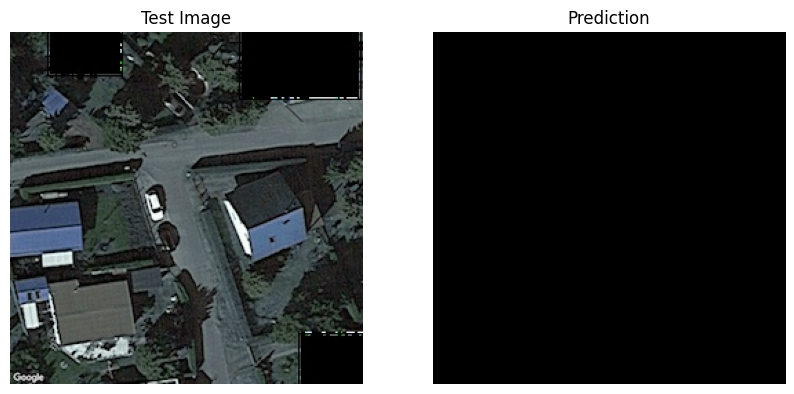

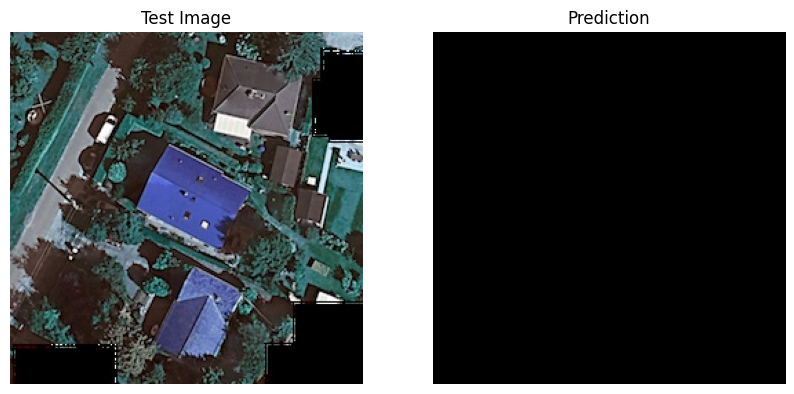

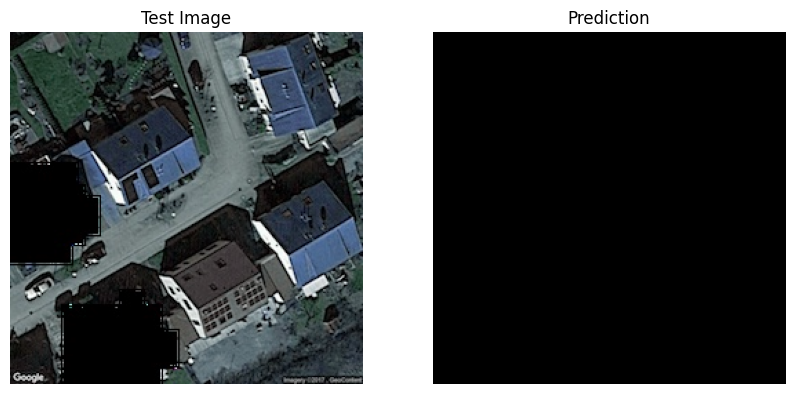

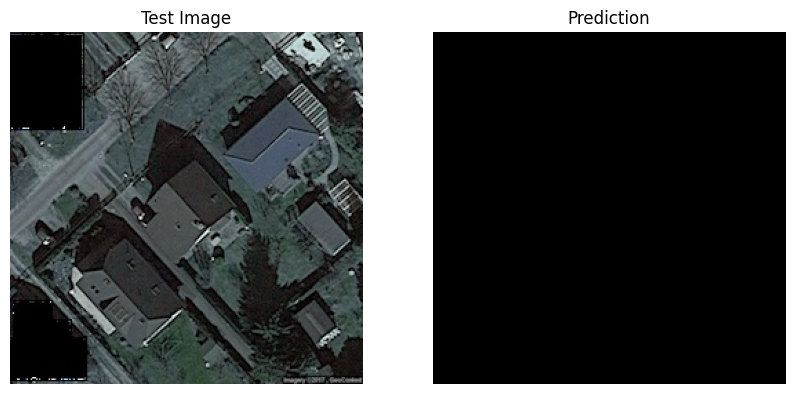

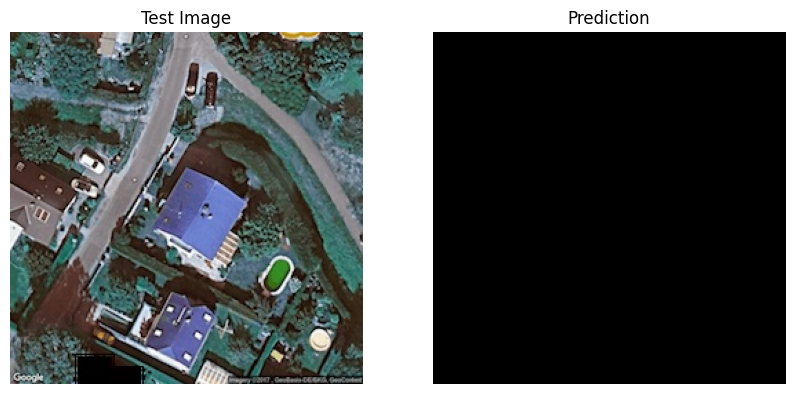

In [ ]:
# Assuming you have the same number of test images and predictions
for i in range(len(test_images)):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    # Display test image
    axes[0].imshow(test_images[i])
    axes[0].set_title('Test Image')
    axes[0].axis('off')
    
    # Display prediction
    axes[1].imshow(processed_predictions[i], cmap='gray')
    axes[1].set_title('Prediction')
    axes[1].axis('off')
    
    plt.show()